In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics.cluster import homogeneity_score
from collections import Counter
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, append=True)

In [2]:
def visualize_embeddings_tSNE(emb_matrix, word_types):
    print("Running tSNE on", emb_matrix.shape, "-dim data")
    tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=250)
    tsne_results = tsne.fit_transform(emb_matrix)
    print('t-SNE done!')
    df_tsne = {'word_type': word_types}
    df_tsne['ax1'] = tsne_results[:, 0]
    df_tsne['ax2'] = tsne_results[:, 1]
    ### Plot data with Plotly
    fig = px.scatter(df_tsne,
                     x='ax1',
                     y='ax2',
                     color='word_type',
                     opacity=0.3
                     )
    fig.update_traces(mode='markers', marker_size=8)
    fig.update_layout(coloraxis={"colorbar":{"dtick":1}})
    fig.update_xaxes(visible=False, showticklabels=False)
    fig.update_yaxes(visible=False, showticklabels=False)
    fig.update_layout(legend=dict(font=dict(size=10)))
    fig.show()
    #save_filename = "figures/ctm_topic_space-tsne-train3000-no_bg.html"
    #fig.write_html(save_filename)


In [3]:
def visualize_embeddings_PCA(emb_matrix, word_types):
    print("Running PCA on", emb_matrix.shape, "-dim matrix")
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(emb_matrix)
    df_pca = {'word_type': word_types}
    df_pca['PC1'] = pca_result[:, 0]
    df_pca['PC2'] = pca_result[:, 1]
    ### Plot data with Plotly
    fig = px.scatter(df_pca,
                     x='PC1',
                     y='PC2',
                     color='word_type',
                     opacity=0.3
                     )
    fig.update_traces(mode='markers', marker_size=8)
    fig.update_layout(coloraxis={"colorbar":{"dtick":1}})
    fig.update_xaxes(visible=False, showticklabels=False)
    fig.update_yaxes(visible=False, showticklabels=False)
    # fig.update_layout(paper_bgcolor="rgba(0,0,0,0)", plot_bgcolor="rgba(0,0,0,0)")
    fig.show()

In [4]:
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

In [5]:
tasks = ['P', 'C', 'T']

df = pd.read_csv("concreteness_norms_last_hidden_state_embs.csv")

df["task"] = [m.split("/")[0] for m in df.model.tolist()]
df["task"].replace(to_replace="paraphrase", value="P", inplace=True)
df["task"].replace(to_replace="captioning", value="C", inplace=True)
df["task"].replace(to_replace="translation", value="T", inplace=True)
df.task.value_counts()

task
C    96720
P    96720
T    96720
Name: count, dtype: int64

In [48]:
def compute_purity(data):
    emb_matrix = np.array(data.iloc[:,:512])
    true_labels = data.word_type.tolist()
    kmeans = KMeans(n_clusters=2).fit(emb_matrix)
    y_pred = kmeans.labels_
    purity = purity_score(true_labels, y_pred)
    # print('purity:', purity)
    return purity

def compute_purity_balance_data(data, shuffle_data=True):
    word_type_counts = data.word_type.value_counts()
    abstract = data[data.word_type == 'abstract']
    if shuffle_data is True:
        concrete = data[data.word_type == 'concrete'].sample(frac=1)
        concrete = concrete[:word_type_counts['abstract']]
    else:
        concrete = data[data.word_type == 'concrete'][:word_type_counts['abstract']]
    balanced_data = pd.concat([abstract, concrete])
    emb_matrix = np.array(balanced_data.iloc[:,:512])
    true_labels = balanced_data.word_type.tolist()
    kmeans = KMeans(n_clusters=2).fit(emb_matrix)
    y_pred = kmeans.labels_
    purity = purity_score(true_labels, y_pred)
    # print('purity:', purity)
    return purity

task_purity = {'task':[], 
               'purity':[]}
for task in tasks:
    print('Task:', task.upper())
    task_models = df[df.task == task]
    model_purity = task_models.groupby("model").apply(lambda x: compute_purity_balance_data(x))
    print('mean:', model_purity.mean())
    print('std:', model_purity.std())
    task_purity['purity'].extend(model_purity.tolist())
    task_purity['task'].extend([task]*len(model_purity))

Task: P
mean: 0.8283205619412517
std: 0.027018613692805556
Task: C
mean: 0.827618135376756
std: 0.02954383701995893
Task: T
mean: 0.8443326947637292
std: 0.019805684005093565


<AxesSubplot:xlabel='task', ylabel='purity'>

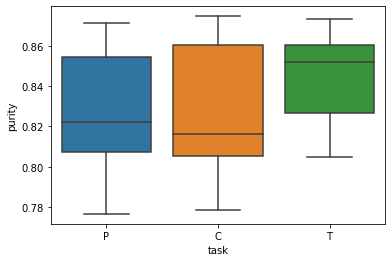

In [49]:
import seaborn as sns
task_purity = pd.DataFrame.from_dict(task_purity)
sns.boxplot(data=task_purity, x="task", y="purity")

In [52]:
from scipy.stats import kruskal
P_purity = task_purity[task_purity.task == 'P'].purity.to_list()
C_purity = task_purity[task_purity.task == 'C'].purity.to_list()
T_purity = task_purity[task_purity.task == 'T'].purity.to_list()
print("P vs C:", kruskal(P_purity, C_purity))
print("P vs T:", kruskal(P_purity, T_purity))
print("C vs T:", kruskal(C_purity, T_purity))

P vs C: KruskalResult(statistic=0.0066921678977371205, pvalue=0.9348012459490413)
P vs T: KruskalResult(statistic=7.736055386852046, pvalue=0.005412891672880406)
C vs T: KruskalResult(statistic=6.5536322281104695, pvalue=0.010467026741771133)


In [47]:
model_name = 'translation/downsample-n-none/5/translation_none_e10.pt'
concrete = df[(df.model == model_name) & (df.word_type == 'concrete')][:783]
abstract = df[(df.model == model_name) & (df.word_type == 'abstract')]
balance = pd.concat([concrete, abstract])
balance.word_type.value_counts()
df[df.model == model_name].word_type.value_counts()

word_type
concrete    1635
abstract     783
Name: count, dtype: int64